# Authors:
##### Maria Musiał : 156062
##### Joanna Szczublińska : 156xxx
##### Wiktoria Szarzyńska : 156xxx

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

### Defining dataset class

In [ ]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]


class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor([forward, left], dtype=torch.float32)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
def get_transforms(augument=True):
    """Create transformations for training and validation"""
    common_transforms = [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    if augument:
        # Transformations: resize to 224x224, color jitter, normalize for rgb values predefined using imagenet 
        train_transforms = [
            transforms.ColorJitter(brightness=0.3, contrast=0.7, saturation=0.3, hue=0.7, p=1),  #color transofmrations 
            transforms.GaussianBlur(sigma_limit=(3.0, 7.0),  blur_limit=0, p=1.0),
            transforms.RandomRotation(10),
            *common_transforms
        ]  
        return transforms.Compose(train_transforms)
    else:
        return transforms.Compose(common_transforms)

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_samples_per_folder(dataset):
    folder_counts = defaultdict(int)
    for img_path, _, _ in dataset.samples:
        folder = os.path.basename(os.path.dirname(img_path))
        folder_counts[folder] += 1
    
    folders = list(folder_counts.keys())
    counts = [folder_counts[f] for f in folders]
    
    plt.figure(figsize=(12, 6))
    plt.bar(folders, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("Samples per Folder")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()


def show_sample_images(dataset, num=9):
    indices = np.random.choice(len(dataset), num, replace=False)
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img, (fwd, left) = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Fwd: {fwd:.2f}, Left: {left:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_target_distributions(dataset):
    forward_vals = [s[1] for s in dataset.samples]
    left_vals = [s[2] for s in dataset.samples]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(forward_vals, bins=50, color='skyblue')
    plt.title("Forward Distribution")
    plt.xlabel("Forward")
    
    plt.subplot(1, 3, 2)
    plt.hist(left_vals, bins=50, color='salmon')
    plt.title("Left Distribution")
    plt.xlabel("Left")

    plt.subplot(1, 3, 3)
    plt.scatter(forward_vals, left_vals, alpha=0.3, s=5)
    plt.title("Forward vs Left")
    plt.xlabel("Forward")
    plt.ylabel("Left")

    plt.tight_layout()
    plt.show()



Loaded 7584 samples from 13 folders


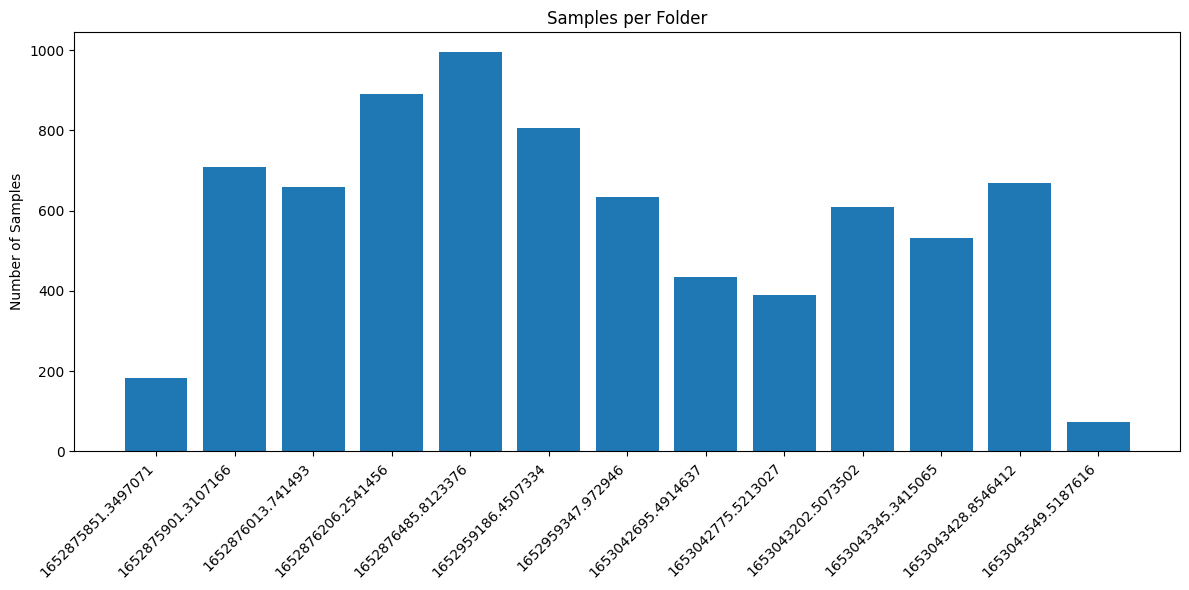

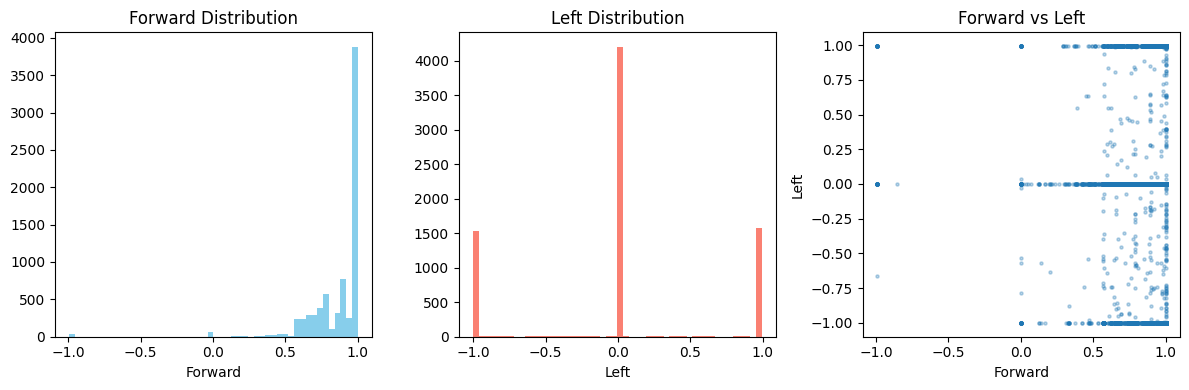

AttributeError: 'Image' object has no attribute 'permute'

<Figure size 1200x1200 with 0 Axes>

In [5]:
train_dataset = JetBotDataset(root_dir="../put_jetbot_dataset/dataset/", transform=None)

plot_samples_per_folder(train_dataset)
plot_target_distributions(train_dataset)
show_sample_images(train_dataset, num=9)


### Dividing dataset to train, test, validation

In [ ]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Get transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset with dummy transform (we'll override it in subsets)
    full_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(full_dataset)

    # Compute lengths
    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    # Split dataset
    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # Assign transforms manually (they use the same dataset class)
    train_set.dataset.transform = train_transform
    val_set.dataset.transform = val_test_transform
    test_set.dataset.transform = val_test_transform

    # Optionally return DataLoaders
    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }


### Divide to train and test

In [ ]:
# from torch.utils.data import random_split

# generator = torch.Generator().manual_seed(44)
# num_test = int(len(dataset) * 0.2)
# train_dataset, test_dataset = random_split(dataset, [len(dataset) - num_test, num_test], generator= generator)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# data = create_datasets(root_dir = "put_jetbot_dataset/dataset/", batch_size=8)
# train_loader = data["train"]
# val_loader = data["val"]
# test_loader = data["test"]


## Displaying dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Function to unnormalize using ImageNet stats
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Show a batch of images from DataLoader
def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Unnormalize all images in the batch
    unnorm_images = unnormalize(images.clone())

    # Create a grid and display
    img_grid = torchvision.utils.make_grid(unnorm_images, nrow=5)
    npimg = img_grid.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.imshow(npimg)
    plt.axis("off")

    # Show the [forward, left] labels
    print("Labels (forward, left):")
    for i in range(min(5, labels.size(0))):  # show up to 5 labels
        print(f"{i+1}. {labels[i].tolist()}")

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images[0], labels[0])
# # Example usage (assuming train_loader exists)
# show_batch(train_loader)


### Resnet transfer learning

In [ ]:
# model = models.resnet18(pretrained=True)
# model.fc = torch.nn.Linear(512,2)
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True
# device = torch.device('cpu')
# model = model.to(device)

### Train model to 2 output: forward, left
> Horrible, training takes too long, we're ditching this approach

In [ ]:
# import torch.nn.functional as functional
# import torch.optim as optim


# epochs = 70
# best_model_path = 'best_model_jetbot.pth'
# best_loss = 1e9
# optimizer = optim.Adam(model.parameters())

# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
    
#     for images, targets in iter(train_loader):
#         images = images.to(device)
#         targets = targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = functional.mse_loss(outputs, targets)
#         train_loss += float(loss)
#         loss.backward()
#         optimizer.step()
#     train_loss /= len(train_loader)
    
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for images, targets in iter(test_loader):
#             images = images.to(device)
#             targets = targets.to(device)
#             outputs = model(images)
#             loss = functional.mse_loss(outputs, targets)      
#             test_loss += float(loss)
#     test_loss /= len(test_loader)
        
#     print(f"Train: {train_loss} -- Test: {test_loss}")
#     if test_loss < best_loss:
#         torch.save(model.state_dict(), best_model_path)
#         best_loss = test_loss
        

###  Nvidia paper CNN


In [ ]:
class NvidiaPaperNetwork(nn.Module):
    """implementation of nvidia's end-to-end self driving cars network"""
    def __init__(self):
        super(NvidiaPaperNetwork, self).__init__()
        
        
        self.conv1a = nn.Conv2d(3, 12, kernel_size=3, stride=2, padding=1)
        self.conv1b = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        
        self.conv2a = nn.Conv2d(12, 18, kernel_size=3, stride=2, padding=1)
        self.conv2b = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        
        self.conv3a = nn.Conv2d(18, 24, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # 224 -> 112 -> 56 -> 28 -> 14 -> 14 after all conv layers
        feature_size = 32 *14*14  #32 channels of 28x28
        self.fc1 = nn.Linear(feature_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.output = nn.Linear(10, 2)  # Output of 2 values: forward, left
        
    def forward(self, x):
        
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        x = x.view(x.size(0), -1)  #Flatten the output 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.output(x)
        
        return x
    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = NvidiaPaperNetwork().to(device)

Using device: cpu


In [ ]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
NvidiaPaperNetwork(
  (conv1a): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(12, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2b): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(18, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
)

Total parameters: 435,756


In [ ]:
def training(model, train_loader, val_loader, device, epochs=70):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 7
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = F.mse_loss(outputs, targets)
            
            train_loss += float(loss)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss = F.mse_loss(outputs, targets)      
                val_loss += float(loss)
                
                # Update progress bar
                val_iterator.set_postfix(loss=float(loss))
                
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and visualise predictions
    """
    
    model.eval()
    all_targets = []
    all_predictions = []
    test_loss = 0.0
    
    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc=f"Evaluating")

        for images, targets in test_iterator:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            
            loss = F.mse_loss(outputs, targets)
            test_loss += float(loss)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
            
            test_iterator.set_postfix(loss=float(loss))
            
        test_loss /= len(test_loader)
        print(f"Final test loss: {test_loss:.6f}")  
        
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    
    # Calculate Mean Absolute Error for each output dimension
    mae = np.mean(np.abs(all_predictions - all_targets), axis=0)
    print(f"Mean Absolute Error per output: {mae}")
    
    # Visualize predictions vs targets (assuming 2D outputs, e.g., x, y coordinates)
    if all_predictions.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(all_targets[:, 0], all_targets[:, 1], c='blue', alpha=0.5, label='Ground Truth')
        plt.scatter(all_predictions[:, 0], all_predictions[:, 1], c='red', alpha=0.5, label='Predictions')
        plt.xlabel('forward')
        plt.ylabel('left')
        plt.title('Predictions vs Ground Truth')
        plt.legend()
        plt.grid(True)
        plt.savefig('predictions_vs_ground_truth.png')
        plt.show()
    
    return test_loss, mae

Using device: cpu


c:\Users\mary9\anaconda3\envs\cv_lab\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loaded 7584 samples from 13 folders
NvidiaPaperNetwork(
  (conv1a): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(12, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2b): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(18, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
)
Total parameters: 435,756


Epoch 1/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.82it/s, loss=0.16]  


Epoch 1/70 - Train loss: 0.244144 - Val loss: 0.234544
New best model saved with val loss: 0.234544


Epoch 2/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.39it/s, loss=0.163]  


Epoch 2/70 - Train loss: 0.233863 - Val loss: 0.231625
New best model saved with val loss: 0.231625


Epoch 3/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.63it/s, loss=0.0344]


Epoch 3/70 - Train loss: 0.162381 - Val loss: 0.109872
New best model saved with val loss: 0.109872


Epoch 4/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.76it/s, loss=0.0341]


Epoch 4/70 - Train loss: 0.108603 - Val loss: 0.109642
New best model saved with val loss: 0.109642


Epoch 5/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.25it/s, loss=0.0701]


Epoch 5/70 - Train loss: 0.102253 - Val loss: 0.106854
New best model saved with val loss: 0.106854


Epoch 6/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 19.02it/s, loss=0.0493]


Epoch 6/70 - Train loss: 0.097510 - Val loss: 0.098351
New best model saved with val loss: 0.098351


Epoch 7/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.54it/s, loss=0.043] 


Epoch 7/70 - Train loss: 0.094575 - Val loss: 0.098164
New best model saved with val loss: 0.098164


Epoch 8/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.19it/s, loss=0.0525]


Epoch 8/70 - Train loss: 0.090985 - Val loss: 0.098838


Epoch 9/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 19.45it/s, loss=0.0237] 


Epoch 9/70 - Train loss: 0.087221 - Val loss: 0.092334
New best model saved with val loss: 0.092334


Epoch 10/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.42it/s, loss=0.0533]


Epoch 10/70 - Train loss: 0.085739 - Val loss: 0.091173
New best model saved with val loss: 0.091173


Epoch 11/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.90it/s, loss=0.0558]


Epoch 11/70 - Train loss: 0.081899 - Val loss: 0.090068
New best model saved with val loss: 0.090068


Epoch 12/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 19.30it/s, loss=0.0301] 


Epoch 12/70 - Train loss: 0.078776 - Val loss: 0.091640


Epoch 13/70 [Test]: 100%|██████████| 143/143 [00:10<00:00, 13.31it/s, loss=0.0359] 


Epoch 13/70 - Train loss: 0.076506 - Val loss: 0.087539
New best model saved with val loss: 0.087539


Epoch 14/70 [Test]: 100%|██████████| 143/143 [00:10<00:00, 13.81it/s, loss=0.048] 


Epoch 14/70 - Train loss: 0.074253 - Val loss: 0.091160


Epoch 15/70 [Test]: 100%|██████████| 143/143 [00:11<00:00, 12.87it/s, loss=0.0227]


Epoch 15/70 - Train loss: 0.071134 - Val loss: 0.088529


Epoch 16/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.84it/s, loss=0.0598]


Epoch 16/70 - Train loss: 0.068486 - Val loss: 0.091884


Epoch 17/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.12it/s, loss=0.0274]


Epoch 17/70 - Train loss: 0.066090 - Val loss: 0.090965


Epoch 18/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.75it/s, loss=0.0163]


Epoch 18/70 - Train loss: 0.062700 - Val loss: 0.084937
New best model saved with val loss: 0.084937


Epoch 19/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.88it/s, loss=0.0458]


Epoch 19/70 - Train loss: 0.061130 - Val loss: 0.094745


Epoch 20/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.80it/s, loss=0.0327] 


Epoch 20/70 - Train loss: 0.058541 - Val loss: 0.086001


Epoch 21/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.99it/s, loss=0.019]  


Epoch 21/70 - Train loss: 0.055848 - Val loss: 0.086389


Epoch 22/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.30it/s, loss=0.0146] 


Epoch 22/70 - Train loss: 0.052930 - Val loss: 0.090861


Epoch 23/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.76it/s, loss=0.0149]


Epoch 23/70 - Train loss: 0.050275 - Val loss: 0.091269


Epoch 24/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.93it/s, loss=0.0111] 


Epoch 24/70 - Train loss: 0.046714 - Val loss: 0.094057


Epoch 25/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.42it/s, loss=0.00637]


Epoch 25/70 - Train loss: 0.039623 - Val loss: 0.089267


Epoch 26/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.27it/s, loss=0.0126] 


Epoch 26/70 - Train loss: 0.036925 - Val loss: 0.091236


Epoch 27/70 [Test]: 100%|██████████| 143/143 [00:09<00:00, 14.93it/s, loss=0.00967]


Epoch 27/70 - Train loss: 0.035142 - Val loss: 0.091322


Epoch 28/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.13it/s, loss=0.00938]


Epoch 28/70 - Train loss: 0.033434 - Val loss: 0.090547


Epoch 29/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.05it/s, loss=0.00804]


Epoch 29/70 - Train loss: 0.031635 - Val loss: 0.093531


Epoch 30/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 17.91it/s, loss=0.00958]


Epoch 30/70 - Train loss: 0.029927 - Val loss: 0.093758


Epoch 31/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 19.03it/s, loss=0.00907]


Epoch 31/70 - Train loss: 0.026066 - Val loss: 0.092884


Epoch 32/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.29it/s, loss=0.01]  


Epoch 32/70 - Train loss: 0.024915 - Val loss: 0.092708


Epoch 33/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.21it/s, loss=0.00889]


Epoch 33/70 - Train loss: 0.023757 - Val loss: 0.091243


Epoch 34/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.90it/s, loss=0.00857]


Epoch 34/70 - Train loss: 0.022860 - Val loss: 0.092515


Epoch 35/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.28it/s, loss=0.00969]


Epoch 35/70 - Train loss: 0.021915 - Val loss: 0.094568


Epoch 36/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.03it/s, loss=0.00804]


Epoch 36/70 - Train loss: 0.020922 - Val loss: 0.094464


Epoch 37/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.28it/s, loss=0.00849]


Epoch 37/70 - Train loss: 0.018904 - Val loss: 0.095690


Epoch 38/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.42it/s, loss=0.00845]


Epoch 38/70 - Train loss: 0.018191 - Val loss: 0.094442


Epoch 39/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.50it/s, loss=0.0082]


Epoch 39/70 - Train loss: 0.017807 - Val loss: 0.095377


Epoch 40/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.44it/s, loss=0.00809]


Epoch 40/70 - Train loss: 0.017217 - Val loss: 0.095880


Epoch 41/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.02it/s, loss=0.00839]


Epoch 41/70 - Train loss: 0.016710 - Val loss: 0.094923


Epoch 42/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.10it/s, loss=0.00703]


Epoch 42/70 - Train loss: 0.016284 - Val loss: 0.095895


Epoch 43/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 18.11it/s, loss=0.00825]


Epoch 43/70 - Train loss: 0.015233 - Val loss: 0.096863


Epoch 44/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.46it/s, loss=0.00763]


Epoch 44/70 - Train loss: 0.014893 - Val loss: 0.096191


Epoch 45/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.51it/s, loss=0.00791]


Epoch 45/70 - Train loss: 0.014660 - Val loss: 0.097440


Epoch 46/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.23it/s, loss=0.00756]


Epoch 46/70 - Train loss: 0.014362 - Val loss: 0.096914


Epoch 47/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.55it/s, loss=0.00842]


Epoch 47/70 - Train loss: 0.014124 - Val loss: 0.097691


Epoch 48/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.90it/s, loss=0.00826]


Epoch 48/70 - Train loss: 0.013913 - Val loss: 0.097807


Epoch 49/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.10it/s, loss=0.00795]


Epoch 49/70 - Train loss: 0.013408 - Val loss: 0.097067


Epoch 50/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.12it/s, loss=0.00838]


Epoch 50/70 - Train loss: 0.013253 - Val loss: 0.097024


Epoch 51/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.23it/s, loss=0.00771]


Epoch 51/70 - Train loss: 0.013131 - Val loss: 0.097609


Epoch 52/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.24it/s, loss=0.0083]


Epoch 52/70 - Train loss: 0.012966 - Val loss: 0.097257


Epoch 53/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.53it/s, loss=0.00784]


Epoch 53/70 - Train loss: 0.012884 - Val loss: 0.097021


Epoch 54/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.46it/s, loss=0.00775]


Epoch 54/70 - Train loss: 0.012763 - Val loss: 0.097864


Epoch 55/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.32it/s, loss=0.00789]


Epoch 55/70 - Train loss: 0.012502 - Val loss: 0.097649


Epoch 56/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 16.70it/s, loss=0.00777]


Epoch 56/70 - Train loss: 0.012431 - Val loss: 0.097611


Epoch 57/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.47it/s, loss=0.008] 


Epoch 57/70 - Train loss: 0.012373 - Val loss: 0.098162


Epoch 58/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.56it/s, loss=0.0081]


Epoch 58/70 - Train loss: 0.012306 - Val loss: 0.098102


Epoch 59/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.20it/s, loss=0.00816]


Epoch 59/70 - Train loss: 0.012239 - Val loss: 0.098305


Epoch 60/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.58it/s, loss=0.00821]


Epoch 60/70 - Train loss: 0.012172 - Val loss: 0.098124


Epoch 61/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.65it/s, loss=0.00811]


Epoch 61/70 - Train loss: 0.012042 - Val loss: 0.098297


Epoch 62/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.26it/s, loss=0.00798]


Epoch 62/70 - Train loss: 0.011999 - Val loss: 0.098004


Epoch 63/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.68it/s, loss=0.00802]


Epoch 63/70 - Train loss: 0.011978 - Val loss: 0.098123


Epoch 64/70 [Test]: 100%|██████████| 143/143 [00:10<00:00, 13.80it/s, loss=0.00809]


Epoch 64/70 - Train loss: 0.011947 - Val loss: 0.098149


Epoch 65/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.38it/s, loss=0.00795]


Epoch 65/70 - Train loss: 0.011929 - Val loss: 0.098276


Epoch 66/70 [Test]: 100%|██████████| 143/143 [00:07<00:00, 17.90it/s, loss=0.00794]


Epoch 66/70 - Train loss: 0.011903 - Val loss: 0.098306


Epoch 67/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.27it/s, loss=0.00798]


Epoch 67/70 - Train loss: 0.011814 - Val loss: 0.098263


Epoch 68/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.39it/s, loss=0.00798]


Epoch 68/70 - Train loss: 0.011802 - Val loss: 0.098350


Epoch 69/70 [Test]: 100%|██████████| 143/143 [00:08<00:00, 17.19it/s, loss=0.00795]


Epoch 69/70 - Train loss: 0.011781 - Val loss: 0.098364


Epoch 70/70 [Test]: 100%|██████████| 143/143 [00:09<00:00, 15.77it/s, loss=0.00793]


Epoch 70/70 - Train loss: 0.011764 - Val loss: 0.098341
Training completed. Best val loss: 0.084937


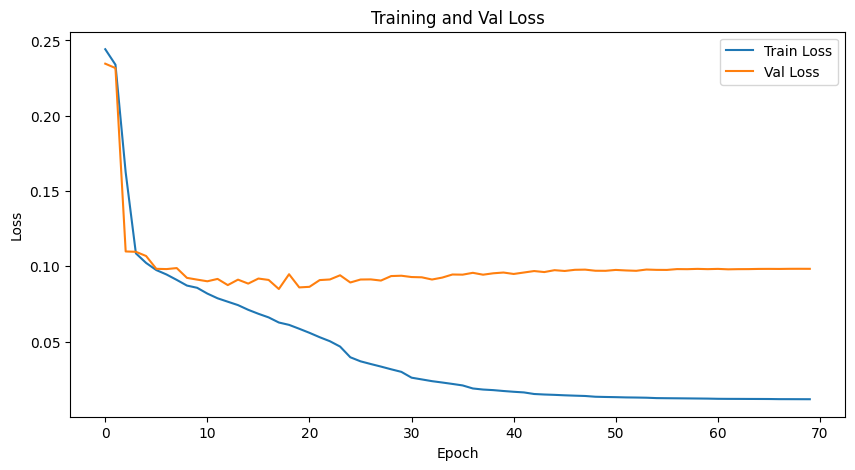

C:\Users\mary9\AppData\Local\Temp\ipykernel_41972\1545001556.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
Evaluati

UnboundLocalError: local variable 'test_loss' referenced before assignment

In [ ]:
root_dir = "put_jetbot_dataset/dataset/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = create_datasets(root_dir = "put_jetbot_dataset/dataset/", batch_size=8)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

# Create model and move to device
model = NvidiaPaperNetwork().to(device)

# Print model summary
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Train the model
# best_model_path = training(model, train_loader, test_loader, device, epochs=70)

# Load the best model
model.load_state_dict(torch.load(best_model_path))


Evaluating: 100%|██████████| 143/143 [00:08<00:00, 16.76it/s, loss=0.0163]


Final test loss: 0.084937
Mean Absolute Error per output: [0.10461389 0.2586747 ]


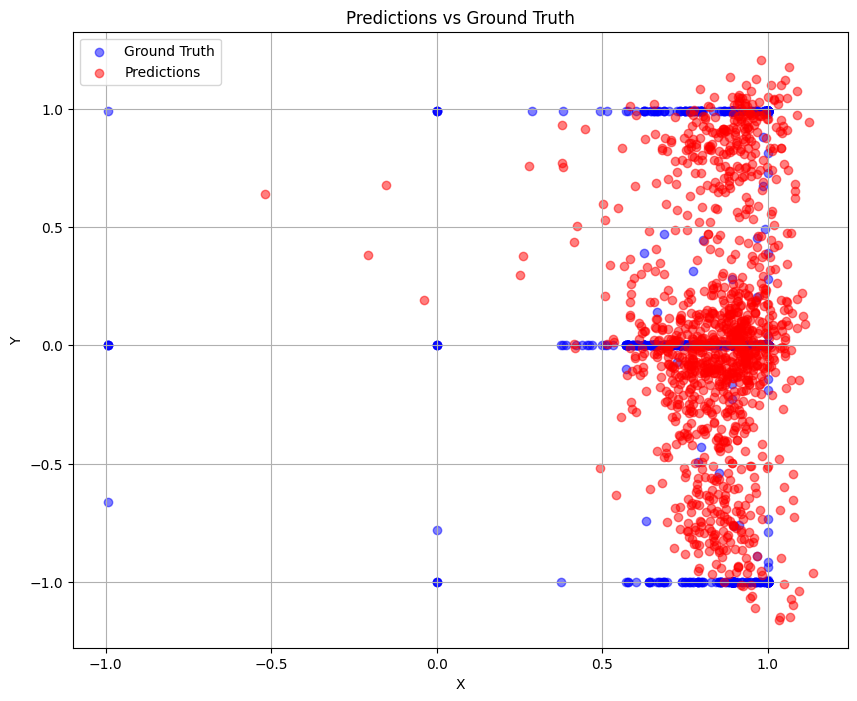

(0.08493707007956464, array([0.10461389, 0.2586747 ], dtype=float32))

In [ ]:
# Evaluate the model
evaluate_model(model, test_loader, device)

## Exporting the model

In [ ]:
model.eval()

import torch

# Assuming your model takes a (3, 224, 224) image as input
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

import torch.onnx

# Path where the ONNX model will be saved
onnx_model_path = "model_jetbot.onnx"

# Exporting the model
torch.onnx.export(
    model,               # Model to export
    dummy_input,         # Example input tensor
    onnx_model_path,     # Path to save the ONNX file
    opset_version=11,    # Define the ONNX opset version
    input_names=["input"],       # Name of the input node
    output_names=["output"],     # Name of the output node
    dynamic_axes={
        "input": {0: "batch_size"},  # Dynamic batch size
        "output": {0: "batch_size"}  # Dynamic batch size
    },
    do_constant_folding=True,  # Enable constant folding optimization
    verbose=True              # Show detailed export info
)

import onnx

# Load the exported model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")



Model has been successfully exported to ONNX format!
